## **Feature Selection**

In [92]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
import numpy as np
import pandas as pd

**Breast Cancer Wisconsin (Diagnostic) Dataset**

*   569 instances (212 Malignant, 357 Benign)
*   30 numerical features (computed from a digitized image of a breast mass)
*   2 classes (Malignant, Benign)

In [93]:
wisconsin = datasets.load_breast_cancer()
TrainX, TestX, TrainY, TestY = train_test_split(wisconsin.data, wisconsin.target, train_size=0.5, random_state=999)
print(TrainX.shape)

(284, 30)


Add random noise

In [94]:
# 각 환자마다 10개의 임의의 값들을 추가한다. (필요없는 10개의 feature를 골랐을 때를 상정한다.)
rTrainX = np.concatenate((TrainX, np.random.randn(TrainX.shape[0], 10)), axis=1)
rTestX = np.concatenate((TestX, np.random.randn(TestX.shape[0], 10)), axis=1)
print(rTrainX.shape)

(284, 40)


In [95]:
# 40개의 feature로 했을 때의 정확도
model = GaussianNB()
model.fit(rTrainX, TrainY)

tr_pred = model.predict(rTrainX)
tr_acc = metrics.accuracy_score(TrainY, tr_pred)

ts_pred = model.predict(rTestX)
ts_acc = metrics.accuracy_score(TestY, ts_pred)

print('Training Accuracy : ', tr_acc)
print('Test Accuracy : ', ts_acc)

Training Accuracy :  0.9507042253521126
Test Accuracy :  0.9438596491228071


**Filter Methods: Select the best K features**

In [96]:
# 40개 중에 k개만 선택을 해보자.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

In [97]:
# mutual_info_class를 사용하여 5개만 뽑아보자!
# 상호정보량(mutual information) : 전체적인 data의 경향이나, 두가지 분포가 얼마나 비슷한가 다른가,,, entropy와 관련도 있으며,,, disqution에 따라서 얼마나 차이가 나나..?
fs_kbest = SelectKBest(mutual_info_classif, k=5)
fs_kbest.fit(rTrainX, TrainY)          # run score function on the data

SelectKBest(k=5, score_func=<function mutual_info_classif at 0x7fc739e752f0>)

In [98]:
# 각 feature의 score가 몇인지.
print('Feature Score : ', fs_kbest.scores_)

Feature Score :  [0.33956329 0.07948527 0.36755099 0.34917436 0.06644114 0.20335035
 0.33085302 0.41714988 0.1189023  0.02020811 0.19257571 0.02065984
 0.24424008 0.31959771 0.02357844 0.05835607 0.09986401 0.09431251
 0.04684966 0.03202221 0.39553327 0.1206942  0.42854196 0.42280539
 0.08795547 0.20507429 0.2598269  0.40331325 0.05536017 0.06909085
 0.         0.02221972 0.01217896 0.         0.01727048 0.01180965
 0.         0.         0.         0.        ]


In [99]:
scores = list(fs_kbest.scores_) # array를 list로 변경
scores_idx = np.argsort(scores) # sorting된 값이 아니라 해당되는 feature를 알려준다.
best5feats = np.sort(scores_idx[-5:])
best5feats

# 10개의 random에서 뽑히지 않았다. (31~40번)

array([ 7, 20, 22, 23, 27])

In [100]:
# 첫번째 사람의 5개 feature 뽑아보기
print(rTrainX[1,best5feats])

[2.944e-02 1.566e+01 1.012e+02 7.500e+02 7.453e-02]


In [101]:
# 위와 같은 내용
sTrainX = fs_kbest.transform(rTrainX)  # select the best K features
sTestX = fs_kbest.transform(rTestX)

print(sTrainX[1,:])

[2.944e-02 1.566e+01 1.012e+02 7.500e+02 7.453e-02]


In [102]:
model_filt = GaussianNB()
model_filt.fit(sTrainX, TrainY)

tr_pred2 = model_filt.predict(sTrainX)
tr_acc2 = metrics.accuracy_score(TrainY, tr_pred2)

ts_pred2 = model_filt.predict(sTestX)
ts_acc2 = metrics.accuracy_score(TestY, ts_pred2)

print('Filter Training Accuracy : ', tr_acc2)
print('Filter Test Accuracy : ', ts_acc2)

# 40개를 사용하나, 5개를 사용하나 거의 비슷하다.

Filter Training Accuracy :  0.9577464788732394
Filter Test Accuracy :  0.9403508771929825


**Wrapper Methods**

In [103]:
from sklearn.feature_selection import SequentialFeatureSelector as sf

Sequential Forward Selection (SFS) - Best k

In [104]:
model_base = GaussianNB()

num_feats_sfsk = 5 # feature 갯수가 5개가 될때까지 진행
# n_features_to_select : 몇개 선택할껀지 / direction : forward, backward / scoring : 평가는 정확도로
# cv : cross-validation, 5개로 나눠서 하나씩 test data로 골라가며 교차검증 (5-fold CV) - 전체를 가지고 training 해버리면 test data가 없다.
# 전체를 가지고 feature를 선택해 놓고 다시 전체에 test하면 제대로 뽑았는지 알 수가 없다.
SFSk = sf(model_base, n_features_to_select=num_feats_sfsk, direction="forward", scoring="accuracy", cv=5)

SFSk.fit(rTrainX, TrainY)

SequentialFeatureSelector(estimator=GaussianNB(), n_features_to_select=5,
                          scoring='accuracy')

In [105]:
print('SFS Selected Features : ', SFSk.get_support())

SFS Selected Features :  [False  True False False False False False False False  True False False
 False False False False False False False False  True False False False
  True False False  True False False False False False False False False
 False False False False]


In [106]:
sfskTrainX = SFSk.transform(rTrainX)
sfskTestX = SFSk.transform(rTestX)

print(sfskTrainX.shape)
print(sfskTestX.shape)

(284, 5)
(285, 5)


In [107]:
model_sfsk = GaussianNB()
model_sfsk.fit(sfskTrainX, TrainY)

tr_pred3 = model_sfsk.predict(sfskTrainX)
tr_acc3 = metrics.accuracy_score(TrainY, tr_pred3)

ts_pred3 = model_sfsk.predict(sfskTestX)
ts_acc3 = metrics.accuracy_score(TestY, ts_pred3)

print('SFS-k Training Accuracy : ', tr_acc3)
print('SFS-k Test Accuracy : ', ts_acc3)

SFS-k Training Accuracy :  0.9647887323943662
SFS-k Test Accuracy :  0.9649122807017544


Sequential Backward Selection (SBS) - Best k

In [108]:
model_base = GaussianNB()

num_feats_sbsk = 15
SBSk = sf(model_base, n_features_to_select=num_feats_sbsk, direction="backward", scoring="accuracy", cv=5)

SBSk.fit(rTrainX, TrainY)

SequentialFeatureSelector(direction='backward', estimator=GaussianNB(),
                          n_features_to_select=15, scoring='accuracy')

In [109]:
print('SBS Selected Features : ', SBSk.get_support())

SBS Selected Features :  [False False False False False False False  True False False  True False
 False  True False False  True False False False  True False  True  True
  True  True  True  True  True  True False False False False False False
 False False  True  True]


In [110]:
sbskTrainX = SBSk.transform(rTrainX)
sbskTestX = SBSk.transform(rTestX)

print(sbskTrainX.shape)
print(sbskTestX.shape)

(284, 15)
(285, 15)


In [111]:
model_sbsk = GaussianNB()
model_sbsk.fit(sbskTrainX, TrainY)

tr_pred4 = model_sbsk.predict(sbskTrainX)
tr_acc4 = metrics.accuracy_score(TrainY, tr_pred4)

ts_pred4 = model_sbsk.predict(sbskTestX)
ts_acc4 = metrics.accuracy_score(TestY, ts_pred4)

print('SBS-k Training Accuracy : ', tr_acc4)
print('SBS-k Test Accuracy : ', ts_acc4)

SBS-k Training Accuracy :  0.9612676056338029
SBS-k Test Accuracy :  0.9403508771929825


Sequential Forward Selection (SFS)

In [116]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sf2

In [118]:
model_base = GaussianNB()
# k_features : 알아서 가장 좋은 경우를 찾아줌 / verbose : 학습의 진행 상황을 보여줄 것인지
SFS = sf2(model_base, k_features="best", forward=True, floating=False, scoring='accuracy', verbose=0, cv=5)
SFS.fit(rTrainX, TrainY)

num_feats_sfs = len(SFS.k_feature_idx_)

print('SFS Selected Features : ', SFS.k_feature_idx_)
print('SFS Selected Number of Features : ', num_feats_sfs)

SFS Selected Features :  (1, 9, 10, 11, 14, 19, 20, 24, 27, 30, 33, 34, 35, 38)
SFS Selected Number of Features :  14


In [122]:
selected_feats = list(SFS.k_feature_idx_)
sfsTrainX = SFS.transform(rTrainX)
sfsTestX = SFS.transform(rTestX)

print(sfsTrainX.shape)
print(sfsTestX.shape)

(284, 14)
(285, 14)


In [123]:
model_sfs = GaussianNB()
model_sfs.fit(sfsTrainX, TrainY)

tr_pred5 = model_sfs.predict(sfsTrainX)
tr_acc5 = metrics.accuracy_score(TrainY, tr_pred5)

ts_pred5 = model_sfs.predict(sfsTestX)
ts_acc5 = metrics.accuracy_score(TestY, ts_pred5)

print('SFS Training Accuracy : ', tr_acc5)
print('SFS Test Accuracy : ', ts_acc5)

SFS Training Accuracy :  0.9753521126760564
SFS Test Accuracy :  0.9578947368421052


Sequential Backward Selection (SBS)

In [125]:
model_base = GaussianNB()

SBS = sf2(model_base, k_features="best", forward=False, floating=False, scoring='accuracy', verbose=0, cv=5)
SBS.fit(rTrainX, TrainY)

num_feats_sbs = len(SBS.k_feature_idx_)

print('SBS Selected Features : ', SBS.k_feature_idx_)
print('SBS Selected Number of Features : ', num_feats_sbs)

SBS Selected Features :  (6, 7, 16, 20, 23, 26, 27)
SBS Selected Number of Features :  7


In [126]:
selected_feats = list(SBS.k_feature_idx_)
sbsTrainX = SBS.transform(rTrainX)
sbsTestX = SBS.transform(rTestX)

print(sbsTrainX.shape)
print(sbsTestX.shape)

(284, 7)
(285, 7)


In [127]:
model_sbs = GaussianNB()
model_sbs.fit(sbsTrainX, TrainY)

tr_pred6 = model_sbs.predict(sbsTrainX)
tr_acc6 = metrics.accuracy_score(TrainY, tr_pred6)

ts_pred6 = model_sbs.predict(sbsTestX)
ts_acc6 = metrics.accuracy_score(TestY, ts_pred6)

print('SBS Training Accuracy : ', tr_acc6)
print('SBS Test Accuracy : ', ts_acc6)

SBS Training Accuracy :  0.9612676056338029
SBS Test Accuracy :  0.9403508771929825


Sequential Floating Forward Selection (SFFS)

In [128]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sf2

In [130]:
model_base = GaussianNB()

SFFS = sf2(model_base, k_features="best", forward=True, floating=True, scoring='accuracy', verbose=0, cv=5)
SFFS.fit(rTrainX, TrainY)

num_feats_sffs = len(SFFS.k_feature_idx_)

print('SFFS Selected Features : ', SFFS.k_feature_idx_)
print('SFFS Selected Number of Features : ', num_feats_sffs)

SFFS Selected Features :  (1, 9, 10, 11, 14, 18, 19, 20, 21, 24, 27, 30, 32, 33, 35, 37, 38)
SFFS Selected Number of Features :  17


In [138]:
selected_feats = list(SFFS.k_feature_idx_)
# sffsTrainX = SFFS.transform(rTrainX)
# sffsTestX = SFFS.transform(rTestX)
sffsTrainX = rTrainX[:, selected_feats]
sffsTestX = rTestX[:, selected_feats]

model_sffs = GaussianNB()
model_sffs.fit(sffsTrainX, TrainY)

tr_pred7 = model_sffs.predict(sffsTrainX)
tr_acc7 = metrics.accuracy_score(TrainY, tr_pred7)

ts_pred7 = model_sffs.predict(sffsTestX)
ts_acc7 = metrics.accuracy_score(TestY, ts_pred7)

print('SFFS Training Accuracy : ', tr_acc7)
print('SFFS Test Accuracy : ', ts_acc7)

SFFS Training Accuracy :  0.9788732394366197
SFFS Test Accuracy :  0.968421052631579


Sequential Floating Backward Selection (SFBS)

In [141]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sf2

model_base = GaussianNB()
SFBS = sf2(model_base, k_features="best", forward=False, floating=True, scoring='accuracy', verbose=0, cv=5)
SFBS.fit(rTrainX, TrainY)

num_feats_sfbs = len(SFBS.k_feature_idx_)

sfbsTrainX = SFBS.transform(rTrainX)
sfbsTestX = SFBS.transform(rTestX)

model_sfbs = GaussianNB()
model_sfbs.fit(sfbsTrainX, TrainY)

tr_pred8 = model_sfbs.predict(sfbsTrainX)
tr_acc8 = metrics.accuracy_score(TrainY, tr_pred8)

ts_pred8 = model_sfbs.predict(sfbsTestX)
ts_acc8 = metrics.accuracy_score(TestY, ts_pred8)

print('SFBS Training Accuracy : ', tr_acc8)
print('SFBS Test Accuracy : ', ts_acc8)

SFBS Training Accuracy :  0.9683098591549296
SFBS Test Accuracy :  0.9719298245614035


Summary

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
df = pd.DataFrame({'Train': [tr_acc, tr_acc2, tr_acc3, tr_acc4, tr_acc5, tr_acc6, tr_acc7, tr_acc8], 
                   'Test': [ts_acc, ts_acc2, ts_acc3, ts_acc4, ts_acc5, ts_acc6, ts_acc7, tr_acc8],
                  'N_feats': [40, 5, num_feats_sfsk, num_feats_sbsk, num_feats_sfs, num_feats_sbs, num_feats_sffs, num_feats_sfbs]})
df.index = ['None', 'BestK', 'SFS-k', 'SBS-k', 'SFS', 'SBS', 'SFFS', 'SFBS']

print(df)

          Train      Test  N_feats
None   0.950704  0.943860       40
BestK  0.957746  0.940351        5
SFS-k  0.964789  0.964912        5
SBS-k  0.961268  0.940351       15
SFS    0.975352  0.957895       14
SBS    0.961268  0.940351        7
SFFS   0.978873  0.968421       17
SFBS   0.968310  0.968310        9


<AxesSubplot:>

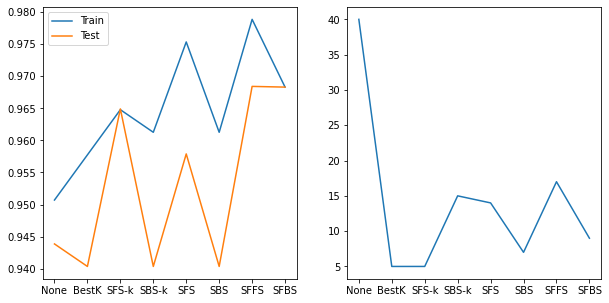

In [143]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
df[['Train','Test']].plot(ax=ax1)
df['N_feats'].plot(ax=ax2)